In [13]:
import numpy as np
import os
from astropy.io import fits
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import astropy.units as u
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from IPython.display import display, Image
from specutils import Spectrum1D, SpectralRegion
from spectral_cube import SpectralCube
from specutils.analysis import moment
from specutils.manipulation import spectral_slab
from astropy.modeling import models, fitting
from spectral_cube import SpectralCube
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.stats import kurtosis

work_dir = os.getcwd()


In [14]:
# def plot_channel(channel_index, data):
#     plt.figure(figsize=(8, 6))
#     plt.imshow(data[channel_index, :, :], cmap='gray')
#     plt.colorbar()
#     plt.title(f'Channel {channel_index + 1}/{n_channels}')
#     plt.show()

In [15]:
# filename = r"C:\Users\lsann\Desktop\test\cropped_J0842+12_a_06_TE_muid___A001_X2fb_X3ec.fits"
# cube = SpectralCube.read(filename, format='fits')
# HDUL = fits.open(filename)
# HDUL.info()  
# header = HDUL[0].header
# print(repr(header[0:32])) 
# data = HDUL[0].data  

# n_channels = data.shape[0]
# interact(lambda channel_index: plot_channel(channel_index, data),
#          channel_index=IntSlider(min=0, max=n_channels-1, step=1, value=0, description='Channel'))

# x, y = 128, 128
# spectra = data[x,y,:]
# frequency = np.linspace(0,1577200.14, data.shape[1])
# plt.figure(figsize=(10, 6))
# plt.plot(frequency, spectra, label=f'Spectra at ({x}, {y})')
# plt.xlabel('Frequency')
# plt.ylabel('Jy')
# plt.title('Spectra')
# plt.legend()
# plt.grid(True)
# plt.show()
# integrated_flux = np.sum(data, axis=(0,1))
# plt.figure(figsize=(10, 6))
# plt.plot(frequency, integrated_flux)
# plt.xlabel('Frequency')
# plt.ylabel('Jy')
# plt.title('Integrated flux')
# plt.legend()
# plt.grid(True)
# plt.show()

# mean_image = np.mean(data, axis=(0,1,2))
# std_image = np.std(data, axis=(0,1,2))


# snr_image = mean_image / std_image

# print(f"SNR for entire datacube: {snr_image}")
# print(f"mean : {mean_image}")
# print(f"std: {std_image}")



# HDUL.close()


In [16]:
# filename = r"C:\Users\lsann\Desktop\test\adjusted_simulated.fits"
# with fits.open(filename) as hdul:
#     # Print the information about the FITS file
#     hdul.info()
    
#     # Print the header of the primary HDU
#     print(repr(header[0:32])) 
    
#     # Get data from the primary HDU
#     data = hdul[0].data

# # Print the shape of the data to understand its dimensions
# print("Data shape:", data.shape)

# # Select a specific slice for visualization, e.g., the first image in the 4D array
# # Adjust the indices as needed
# data = np.squeeze(data)
# print(data.shape)

# n_channels = data.shape[0]
# interact(lambda channel_index: plot_channel(channel_index, data),
#          channel_index=IntSlider(min=0, max=n_channels-1, step=1, value=0, description='Channel'))

# x, y = 128, 128
# spectra = data[x, y, :]
# frequency = np.linspace(0,1577200.14, data.shape[1])
# plt.figure(figsize=(10, 6))
# plt.plot(frequency, spectra, label=f'Spectra at ({x}, {y})')
# plt.xlabel('Frequency')
# plt.ylabel('Jy')
# plt.title('Spectra')
# plt.legend()
# plt.grid(True)
# plt.show()
# print(data.shape)
# integrated_flux = np.sum(data, axis=(0,1))
# plt.figure(figsize=(10, 6))
# plt.plot(frequency, integrated_flux)
# plt.xlabel('Frequency')
# plt.ylabel('Jy/beam')
# plt.title('Integrated flux')
# plt.legend()
# plt.grid(True)
# plt.show()

# mean_image = np.mean(data, axis=(0,1,2))
# std_image = np.std(data, axis=(0,1,2))

# # Calcola il SNR per tutti i pixel
# snr_image = mean_image / std_image

# print(f"SNR medio per l'intero datacube: {snr_image}")
# print(f"mean : {mean_image}")
# print(f"std: {std_image}")

# HDUL.close()

Source coordinates (from integrated flux): (x_center, y_center) = (56, 91)
Slice with maximum flux at the source coordinates: 0
Source radius corresponding to 90% of maximum flux: 2
Estimated sigma: 1.0
Background radius: 3
Mean flux in the source region: 0.029583076015114784
Standard deviation in the background region: 0.00839432142674923
SNR in the source region: 3.524177074432373


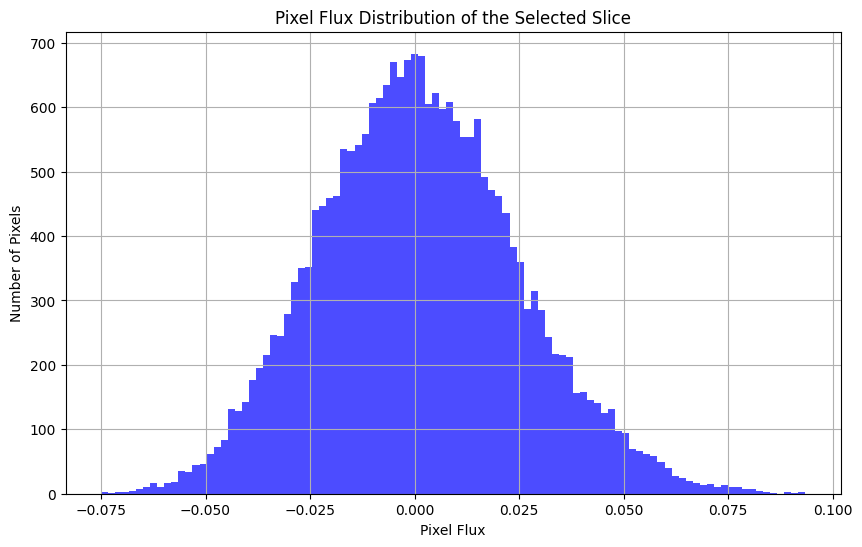

Kurtosis is : 0.002093777887399284


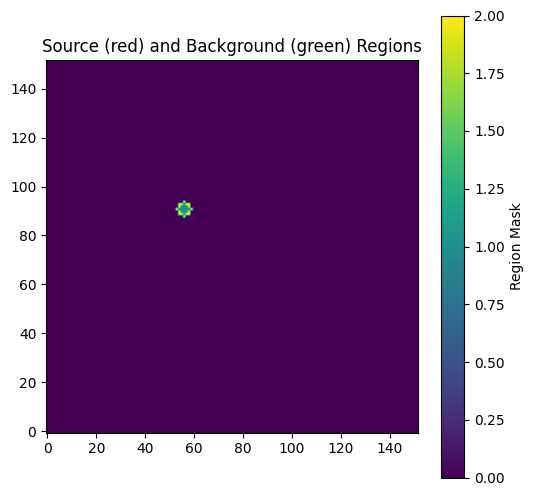

In [17]:
# Load the data
filename = r"C:\Users\lsann\Desktop\test\cropped_J0842+12_a_06_TE_muid___A001_X2fb_X3ec.fits"
HDUL = fits.open(filename)
data = HDUL[0].data  

# Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
integrated_flux = np.sum(data, axis=0)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# Step 2: Identify the slice that contains the maximum flux at the source coordinates
# Extract the flux values at (x_center, y_center) across all slices
source_spectrum = data[:, y_center, x_center]

# Find the slice index with the maximum flux at the source coordinates
max_slice_index = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.9 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 4: Calculate the background radius
background_radius = int(3 * sigma_fit)
print(f"Background radius: {background_radius}")

# Step 5: Create masks for source and background regions in the selected slice
source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
background_mask &= ~source_mask

# Mean of the source region
mean_source = np.mean(slice_data[source_mask])
print(f"Mean flux in the source region: {mean_source}")

# Standard deviation of the background region
std_background = np.std(slice_data[background_mask])
print(f"Standard deviation in the background region: {std_background}")

# Optional: Plot SNR in the source region
snr_source = mean_source / std_background
print(f"SNR in the source region: {snr_source}")

# Step 6: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')
# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()

Source coordinates (from integrated flux): (x_center, y_center) = (75, 75)
Slice with maximum flux at the source coordinates: 484
Source radius corresponding to 90% of maximum flux: 3
Estimated sigma: 1.5
Background radius: 4
Mean flux in the source region: 6.500523141994563e-08
Standard deviation in the background region: 5.957625059949123e-09
SNR in the source region: 10.911266326904297


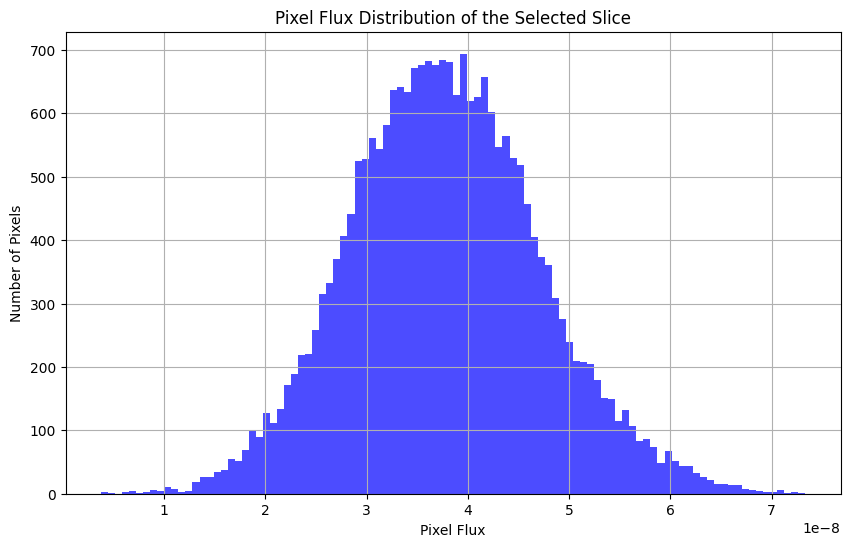

Kurtosis is : 0.0804055138490054


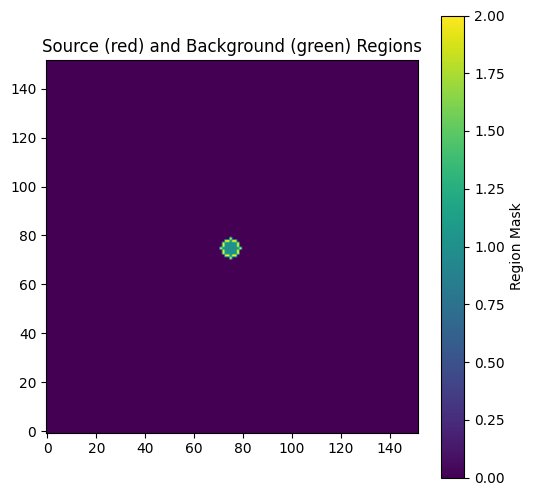

In [18]:
# Load the data
filename = r"C:\Users\lsann\Desktop\test\adjusted_simulated.fits"
# Load the data
HDUL = fits.open(filename)
data = HDUL[0].data  

# Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
integrated_flux = np.sum(data, axis=0)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# Step 2: Identify the slice that contains the maximum flux at the source coordinates
# Extract the flux values at (x_center, y_center) across all slices
source_spectrum = data[:, y_center, x_center]

# Find the slice index with the maximum flux at the source coordinates
max_slice_index = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.9 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 4: Calculate the background radius
background_radius = int(3 * sigma_fit)
print(f"Background radius: {background_radius}")

# Step 5: Create masks for source and background regions in the selected slice
source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
background_mask &= ~source_mask

# Mean of the source region
mean_source = np.mean(slice_data[source_mask])
print(f"Mean flux in the source region: {mean_source}")

# Standard deviation of the background region
std_background = np.std(slice_data[background_mask])
print(f"Standard deviation in the background region: {std_background}")

# Optional: Plot SNR in the source region
snr_source = mean_source / std_background
print(f"SNR in the source region: {snr_source}")

# Step 6: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')
# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()